# Fase 1: Configuracion y Carga de Datos

In [22]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GroupShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [23]:
# define la ruta del dataset exportado
input_path = os.path.join('data_export', 'cleaned_dataset.feather')

# carga el dataframe desde el archivo feather
df = pd.read_feather(input_path)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77422 entries, 0 to 77421
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   username         77422 non-null  object        
 1   datetime         77422 non-null  object        
 2   body             77422 non-null  object        
 3   role             77422 non-null  object        
 4   file             77422 non-null  object        
 5   normalized_body  77422 non-null  object        
 6   word_length      77422 non-null  int64         
 7   datetime_parsed  73845 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 4.7+ MB


# Fase 2: Preparacion de Datos

In [24]:
# agrupamos por archivo, usuario y sus mensajes dentro del chat
user_chats = df.groupby(['file', 'username', 'role'])['normalized_body'].apply(' '.join).reset_index()

# renombra la columna de texto para mayor claridad
user_chats.rename(columns={'normalized_body': 'full_user_text'}, inplace=True)

# filtra roles y les asigna un numero
# 1 predator,  0 victim
user_chats = user_chats[user_chats['role'].isin(['predator', 'victim'])]
user_chats['label'] = user_chats['role'].map({'predator': 1, 'victim': 0})

# verifica el nuevo dataframe
print("--- DataFrame Agrupado por Usuario ---")
print(user_chats.head())
print(f"\nNumero total de muestras (usuarios por chat): {len(user_chats)}")

--- DataFrame Agrupado por Usuario ---
              file      username      role  \
0  ArmySgt1961.xml   armysgt1961  predator   
1  ArmySgt1961.xml  peekaboo1293    victim   
2   Pavlov1234.xml   david 91752    victim   
3   Pavlov1234.xml    pavlov1234  predator   
4     Socal128.xml  riverridzz13    victim   

                                      full_user_text  label  
0  i am dennis us army soldier from cincinnati ho...      1  
1  hi i am becky from ky 13 how old are you yes i...      0  
2  i want to boyf how old are you 13 riverside wh...      0  
3  you down four getting he would i am me if you ...      1  
4  sup bored how old are you you luk that old 13 ...      0  

Numero total de muestras (usuarios por chat): 123


# Fase 3: Division de Datos

In [25]:
# Caracteristicas (X), Etiquetas (y) y grupos (para evitar data leakage)
# Osea, si en train aparece un groomer del chat A, la victima del chat A tambien estara
# asi evitamos filtracion de datos
X = user_chats['full_user_text']
y = user_chats['label']
groups = user_chats['file']

# usa GroupShuffleSplit de sklearn para asegurar que todos los usuarios de un mismo chat
# queden en el mismo conjunto (train o test)
gss = GroupShuffleSplit(n_splits=1, test_size=0.65, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

# verifica que no hay archivos comunes entre train y test
train_files = set(user_chats.iloc[train_idx]['file'])
test_files = set(user_chats.iloc[test_idx]['file'])
assert train_files.isdisjoint(test_files), "Fuga de datos detectada!"

print(f"Tamaño del conjunto de entrenamiento: {len(X_train)}")
print(f"Tamaño del conjunto de prueba: {len(X_test)}")

Tamaño del conjunto de entrenamiento: 44
Tamaño del conjunto de prueba: 79


# Fase 4: Creacion del Pipeline de Modelo

In [26]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# define los parametros comunes para el vectorizador
tfidf_params = {
    'stop_words': 'english',
    'ngram_range': (1, 2),
    'max_features': 10000
}

# crea un diccionario de pipelines para cada modelo
models = {
    'Logistic Regression': Pipeline([
        ('tfidf', TfidfVectorizer(**tfidf_params)),
        ('clf', LogisticRegression(random_state=42, solver='liblinear'))
    ]),
    'Support Vector Machine': Pipeline([
        ('tfidf', TfidfVectorizer(**tfidf_params)),
        ('clf', SVC(kernel='linear', random_state=42))
    ]),
    'Random Forest': Pipeline([
        ('tfidf', TfidfVectorizer(**tfidf_params)),
        ('clf', RandomForestClassifier(n_estimators=100, random_state=42))
    ])
}

# Fase 5: Entrenamiento y Evaluacion del Modelo

In [27]:
results = {}

for name, pipeline in models.items():
    print(f"--- Entrenando: {name} ---")
    
    # entrena el pipeline
    pipeline.fit(X_train, y_train)
    
    # realiza predicciones
    y_pred = pipeline.predict(X_test)
    
    # guarda los resultados
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=['victim (0)', 'predator (1)'], output_dict=True)
    
    results[name] = {
        'accuracy': accuracy,
        'report': report,
        'predictions': y_pred
    }
    
    print(f"Precision para {name}: {accuracy:.4f}\n")

--- Entrenando: Logistic Regression ---
Precision para Logistic Regression: 0.8608

--- Entrenando: Support Vector Machine ---
Precision para Support Vector Machine: 0.8354

--- Entrenando: Random Forest ---
Precision para Random Forest: 0.7342



# Fase 6: Analisis Comparativo de Resultados

### 6.1 Tabla Comparativa de Metricas

In [29]:
comparison_data = []
for name, result in results.items():
    comparison_data.append({
        'Model': name,
        'Accuracy': result['accuracy'],
        'Predator Precision': result['report']['predator (1)']['precision'],
        'Predator Recall': result['report']['predator (1)']['recall'],
        'Predator F1-Score': result['report']['predator (1)']['f1-score']
    })

comparison_df = pd.DataFrame(comparison_data)
print("--- Tabla Comparativa de Modelos ---")
print(comparison_df.to_string())

--- Tabla Comparativa de Modelos ---
                    Model  Accuracy  Predator Precision  Predator Recall  Predator F1-Score
0     Logistic Regression  0.860759            0.837209            0.900           0.867470
1  Support Vector Machine  0.835443            0.909091            0.750           0.821918
2           Random Forest  0.734177            0.672727            0.925           0.778947


### 6.2 Matrices de Confusion

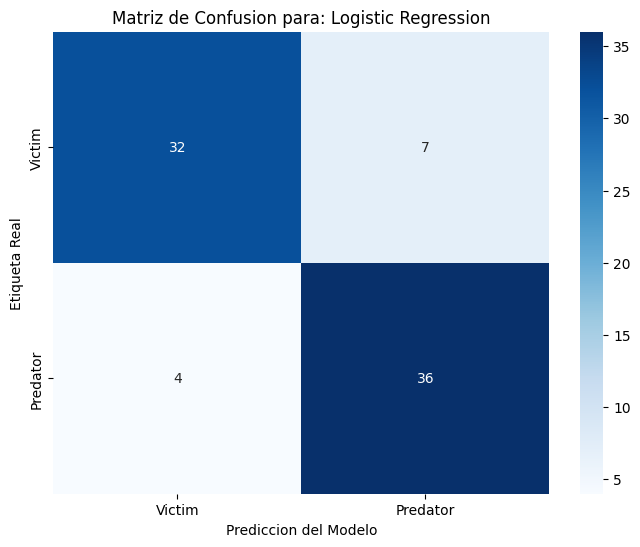

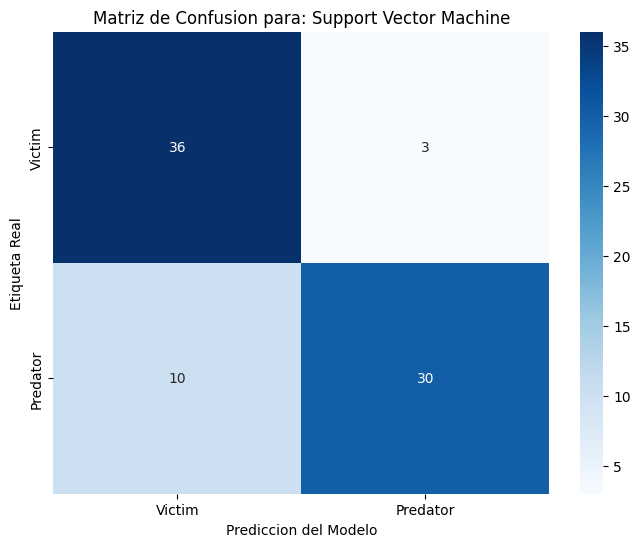

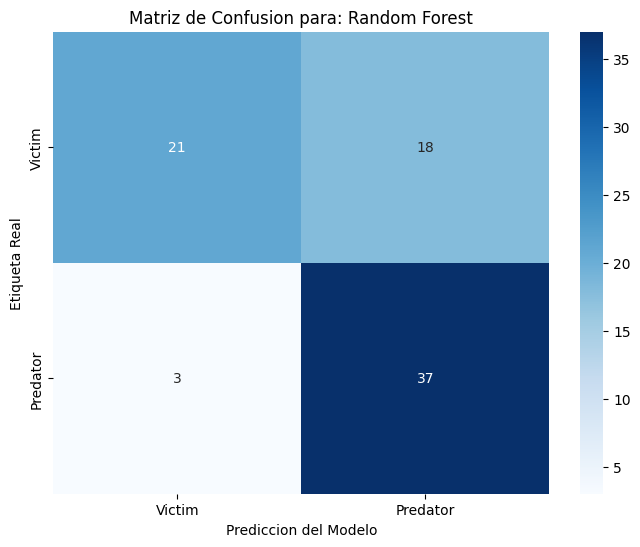

In [30]:
for name, result in results.items():
    cm = confusion_matrix(y_test, result['predictions'])
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Victim', 'Predator'], yticklabels=['Victim', 'Predator'])
    plt.xlabel('Prediccion del Modelo')
    plt.ylabel('Etiqueta Real')
    plt.title(f'Matriz de Confusion para: {name}')
    plt.show()